In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec 11 00:47:28 2019
Detect malware applications (android) through network traffic classification
@author: Riyadh Uddin
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score,roc_curve
#importing lib

In [2]:
# =============================================================================
# load data file
# URL=('www.kaggle.com/xwolf12/android-malware-analysis/data')
# =============================================================================
dataset = pd.read_csv("android_traffic.csv", sep=";")
# =============================================================================
#dataset.head()
#Data cleaning & processing
#dataset.isna().sum()
#We had to drop empty or NAN columns
#dataset.describe()
#now lets check and clean the duplicates
#dataset[dataset.duplicated()].sum()
# =============================================================================

In [3]:
dataset.head()

,name,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times,type
0,AntiVirus,36,6,3,3911,0,0,39,33,5100,4140,NaN,NaN,NaN,39,3,benign
1,AntiVirus,117,0,9,23514,0,0,128,107,26248,24358,NaN,NaN,NaN,128,11,benign
2,AntiVirus,196,0,6,24151,0,0,205,214,163887,24867,NaN,NaN,NaN,205,9,benign
3,AntiVirus,6,0,1,889,0,0,7,6,819,975,NaN,NaN,NaN,7,1,benign
4,AntiVirus,6,0,1,882,0,0,7,6,819,968,NaN,NaN,NaN,7,1,benign


In [4]:
dataset.isna().sum()

name                       0
tcp_packets                0
dist_port_tcp              0
external_ips               0
vulume_bytes               0
udp_packets                0
tcp_urg_packet             0
source_app_packets         0
remote_app_packets         0
source_app_bytes           0
remote_app_bytes           0
duracion                7845
avg_local_pkt_rate      7845
avg_remote_pkt_rate     7845
source_app_packets.1       0
dns_query_times            0
type                       0
dtype: int64

In [5]:
dataset.describe()

,tcp_packets,dist_port_tcp,external_ips,vulume_bytes,udp_packets,tcp_urg_packet,source_app_packets,remote_app_packets,source_app_bytes,remote_app_bytes,duracion,avg_local_pkt_rate,avg_remote_pkt_rate,source_app_packets.1,dns_query_times
count,7845.000000,7845.000000,7845.000000,7.845000e+03,7845.000000,7845.000000,7845.000000,7845.000000,7.845000e+03,7.845000e+03,0.0,0.0,0.0,7845.000000,7845.000000
mean,147.578713,7.738177,2.748502,1.654375e+04,0.056724,0.000255,152.911918,194.706310,2.024967e+05,1.692260e+04,NaN,NaN,NaN,152.911918,4.898917
std,777.920084,51.654222,2.923005,8.225650e+04,1.394046,0.015966,779.034618,1068.112696,1.401076e+06,8.238182e+04,NaN,NaN,NaN,779.034618,18.900478
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000e+00,6.900000e+01,NaN,NaN,NaN,1.000000,0.000000
25%,6.000000,0.000000,1.000000,8.880000e+02,0.000000,0.000000,7.000000,7.000000,9.340000e+02,1.046000e+03,NaN,NaN,NaN,7.000000,1.000000
50%,25.000000,0.000000,2.000000,3.509000e+03,0.000000,0.000000,30.000000,24.000000,4.090000e+03,3.803000e+03,NaN,NaN,NaN,30.000000,3.000000
75%,93.000000,0.000000,4.000000,1.218900e+04,0.000000,0.000000,98.000000,92.000000,2.624400e+04,1.261000e+04,NaN,NaN,NaN,98.000000,5.000000
max,37143.000000,2167.000000,43.000000,4.226790e+06,65.000000,1.000000,37150.000000,45928.000000,6.823516e+07,4.227323e+06,NaN,NaN,NaN,37150.000000,913.000000


In [6]:
dataset[dataset.duplicated()].sum()

name                    AntiVirusAntiVirusAntiVirusAntiVirusAntiVirusA...
tcp_packets                                                         15038
dist_port_tcp                                                        3514
external_ips                                                         1434
vulume_bytes                                                      2061210
udp_packets                                                            38
tcp_urg_packet                                                          0
source_app_packets                                                  21720
remote_app_packets                                                  18841
source_app_bytes                                                  8615120
remote_app_bytes                                                  2456160
duracion                                                                0
avg_local_pkt_rate                                                      0
avg_remote_pkt_rate                   

In [7]:
dataset = dataset.drop(['duracion','avg_local_pkt_rate','avg_remote_pkt_rate','tcp_urg_packet'], axis=1).copy()
dataset=dataset.drop('source_app_packets.1',axis=1).copy()

In [8]:
# =============================================================================
# Feature Scaling
# =============================================================================
scaler = preprocessing.RobustScaler()
scaledData = scaler.fit_transform(dataset.iloc[:,1:11])
scaledData = pd.DataFrame(scaledData, columns=['tcp_packets','dist_port_tcp','external_ips','vulume_bytes','udp_packets','source_app_packets','remote_app_packets',' source_app_bytes','remote_app_bytes','dns_query_times'])

In [9]:
# =============================================================================
# Training and Predictions
# =============================================================================

In [10]:
X_train, X_test, y_train, y_test = train_test_split(scaledData.iloc[:,0:10],dataset.type.astype("str"), test_size=0.33, random_state=101)

In [11]:
# =============================================================================
# K Neighbor classification
# Calculating error for K values 
# =============================================================================

In [12]:
error = []
for i in range(3, 15, 3):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))
    accuracy = accuracy_score(pred_i, y_test)
    print("kneighbors {}".format(i))
    print("Accuracy:",accuracy)
    print("Error:",error)
    print("Confusion Matrix \n",confusion_matrix(y_test, pred_i))
    print("Classification Report: \n",classification_report(y_test, pred_i))

kneighbors 3
Accuracy: 0.8783314020857474
Error: [0.12166859791425261]
Confusion Matrix 
 [[1404  168]
 [ 147  870]]
Classification Report: 
               precision    recall  f1-score   support

      benign       0.91      0.89      0.90      1572
   malicious       0.84      0.86      0.85      1017

    accuracy                           0.88      2589
   macro avg       0.87      0.87      0.87      2589
weighted avg       0.88      0.88      0.88      2589

kneighbors 6
Accuracy: 0.8760139049826188
Error: [0.12166859791425261, 0.12398609501738123]
Confusion Matrix 
 [[1425  147]
 [ 174  843]]
Classification Report: 
               precision    recall  f1-score   support

      benign       0.89      0.91      0.90      1572
   malicious       0.85      0.83      0.84      1017

    accuracy                           0.88      2589
   macro avg       0.87      0.87      0.87      2589
weighted avg       0.88      0.88      0.88      2589

kneighbors 9
Accuracy: 0.8609501738122828

In [13]:
# =============================================================================
# Random Forest Classifier
# =============================================================================

In [14]:
randomForest=RandomForestClassifier(n_estimators=250,
                                    max_depth=50,
                                    bootstrap = True,
                                    random_state=45)
randomForest.fit(X_train,y_train)
pred=randomForest.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print(randomForest)
print("Accuracy:",accuracy)
print("Confusion Matrix \n",confusion_matrix(y_test, pred))
print("Classification Report: \n",classification_report(y_test, pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=250,
                       n_jobs=None, oob_score=False, random_state=45, verbose=0,
                       warm_start=False)
Accuracy: 0.9061413673232909
Confusion Matrix 
 [[1466  106]
 [ 137  880]]
Classification Report: 
               precision    recall  f1-score   support

      benign       0.91      0.93      0.92      1572
   malicious       0.89      0.87      0.88      1017

    accuracy                           0.91      2589
   macro avg       0.90      0.90      0.90      2589
weighted avg       0.91      0.91      0.91      2589



In [15]:
# ============
#xtra coding for roc curve, precision recall will goes here
# =============================================================================
# plt k neighbor error
# =============================================================================

Text(0, 0.5, 'Mean Error')

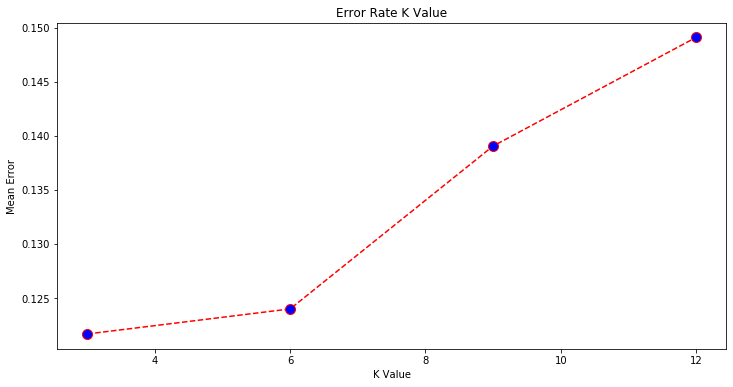

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(range(3,15,3), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')